# **Proyek Analisis Sentimen Review Aplikasi Coinbase**
- **Nama:** Harry Mardika
- **Email:** harrymardika48@gmail.com
- **ID Dicoding:** hkacode

## Alur Kerja:
- Setup & Impor Library
- Fase 1: Akuisisi Data (Scraping) & Pembersihan Awal
- Fase 2: Pelabelan Sentimen & Penyeimbangan Dataset
- Fase 3: Pembersihan Data Mendalam
- Fase 4: Pembagian Data (Train, Validation, Test)
- Fase 5: Ekstraksi Fitur (TF-IDF & Tokenization/Padding + FastText untuk Deep Learning)
- Fase 6: Definisi & Pelatihan Model
    - Eksperimen 1: Artificial Neural Network (ANN)
    - Eksperimen 2: Convolutional Neural Network (CNN)
    - Eksperimen 3: Random Forest (RF) - Scikit-learn
    - Eksperimen 4: XGBoost - Scikit-learn
    - Eksperimen 5: LightGBM - Scikit-learn
- Fase 7: Evaluasi & Pemilihan Model Terbaik
- Fase 8: Inference (Pengujian pada Data Baru)


## Setup & Impor Library

In [1]:
# !pip install google-play-scraper pandas numpy nltk scikit-learn xgboost lightgbm matplotlib seaborn tensorflow torch torchvision torchaudio torch-directml

In [2]:
print("Tahap 1: Setup & Impor Library")

import pandas as pd
import numpy as np
import re
import nltk
import time
import os
import warnings
import random

# Scraping
from google_play_scraper import reviews_all, Sort, reviews

# Text Processing & Labeling
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Pastikan resource NLTK sudah diunduh
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except:
    print("Mengunduh resource NLTK (vader_lexicon)...")
    nltk.download('vader_lexicon')
try:
    nltk.data.find('corpora/stopwords')
except:
    print("Mengunduh resource NLTK (stopwords)...")
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except:
    print("Mengunduh resource NLTK (wordnet)...")
    nltk.download('wordnet')


# Machine Learning & Deep Learning
import fasttext
import fasttext.util
import xgboost as xgb
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# # PyTorch & DirectML
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader

# # Coba impor torch_directml
# try:
#     import torch_directml
#     if torch_directml.is_available():
#         DEVICE = torch_directml.device()
#         print(f"Menggunakan backend DirectML pada perangkat: {torch_directml.device_name(0)}")
#     else:
#         DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         print(f"DirectML tidak tersedia atau tidak terdeteksi. Menggunakan backend PyTorch default: {DEVICE}")
# except ImportError:
#     DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print(f"torch_directml tidak terinstal. Menggunakan backend PyTorch default: {DEVICE}")


# TensorFlow & Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer # Bisa pakai Keras tokenizer untuk kemudahan
from tensorflow.keras.preprocessing.sequence import pad_sequences
print("Menggunakan Device:", tf.test.gpu_device_name() if tf.config.list_physical_devices('GPU') else "CPU")

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Pengaturan Lain
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 150) # Tampilkan teks lebih panjang di Pandas
random.seed(42) # Seed untuk reproduktifitas
np.random.seed(42)

print("Setup selesai.")

Tahap 1: Setup & Impor Library
Mengunduh resource NLTK (wordnet)...


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\harry\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Menggunakan Device: /device:GPU:0
Setup selesai.


In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Fase 1: Akuisisi Data (Scraping) & Pembersihan Awal

In [4]:
print("\nTahap 2: Akuisisi Data & Pembersihan Awal")

# Konfigurasi
APP_ID = 'com.coinbase.android'
LANG = 'en'
COUNTRY = 'us'
NUM_REVIEWS_TARGET = 300000
RAW_CSV_PATH = 'data/reviews_raw.csv'
LIGHT_CLEAN_CSV_PATH = 'data/reviews_lightly_cleaned.csv'


Tahap 2: Akuisisi Data & Pembersihan Awal


In [5]:
# --- Scraping ---
if not os.path.exists(RAW_CSV_PATH):
    print(f"Memulai scraping review untuk {APP_ID}...")
    start_time = time.time()
    try:
        all_reviews = reviews(
            APP_ID,
            lang=LANG,
            country=COUNTRY,
            sort=Sort.NEWEST,
            count=NUM_REVIEWS_TARGET
        )
        
        df_raw = pd.DataFrame(all_reviews[0])
        print(f"Scraping selesai. Mendapatkan {len(df_raw)} review.")
        # Ambil kolom yang relevan saja
        df_raw = df_raw[['reviewId', 'userName', 'content', 'score', 'thumbsUpCount', 'reviewCreatedVersion', 'at']]
        df_raw.rename(columns={'content': 'review_text', 'score': 'rating'}, inplace=True)
        df_raw.to_csv(RAW_CSV_PATH, index=False)
        print(f"Data mentah disimpan ke {RAW_CSV_PATH}")
    except Exception as e:
        print(f"Terjadi error saat scraping: {e}")
        df_raw = pd.DataFrame() # Buat dataframe kosong jika gagal
    end_time = time.time()
    print(f"Waktu scraping: {end_time - start_time:.2f} detik.")
else:
    print(f"Memuat data mentah dari {RAW_CSV_PATH}...")
    df_raw = pd.read_csv(RAW_CSV_PATH)
    print(f"Berhasil memuat {len(df_raw)} review mentah.")

Memuat data mentah dari data/reviews_raw.csv...
Berhasil memuat 172223 review mentah.


In [6]:
# --- Pembersihan Awal (Ringan) ---
if not df_raw.empty and not os.path.exists(LIGHT_CLEAN_CSV_PATH):
    print("Memulai pembersihan awal...")
    df_light_clean = df_raw.copy()

    # Hapus duplikat berdasarkan review_text (kadang ada review sama persis)
    df_light_clean.drop_duplicates(subset=['review_text'], inplace=True)

    # Hapus baris dengan review kosong atau NaN
    df_light_clean.dropna(subset=['review_text'], inplace=True)
    df_light_clean = df_light_clean[df_light_clean['review_text'].str.strip() != '']

    # Konversi tipe data jika perlu (rating harus integer)
    df_light_clean['rating'] = df_light_clean['rating'].astype(int)

    # Pembersihan teks ringan: lowercase
    df_light_clean['review_text_cleaned'] = df_light_clean['review_text'].str.lower()

    # (Opsional) Hapus URL sederhana jika ada
    df_light_clean['review_text_cleaned'] = df_light_clean['review_text_cleaned'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x, flags=re.MULTILINE))
    # (Opsional) Hapus mention @username jika ada
    df_light_clean['review_text_cleaned'] = df_light_clean['review_text_cleaned'].apply(lambda x: re.sub(r'\@\w+', '', x))

    print(f"Pembersihan awal selesai. Jumlah data setelah pembersihan: {len(df_light_clean)}")
    df_light_clean.to_csv(LIGHT_CLEAN_CSV_PATH, index=False)
    print(f"Data hasil pembersihan awal disimpan ke {LIGHT_CLEAN_CSV_PATH}")

elif os.path.exists(LIGHT_CLEAN_CSV_PATH):
     print(f"Memuat data hasil pembersihan awal dari {LIGHT_CLEAN_CSV_PATH}...")
     df_light_clean = pd.read_csv(LIGHT_CLEAN_CSV_PATH)
     # Pastikan kolom utama ada dan tipe data sesuai
     if 'review_text_cleaned' not in df_light_clean.columns and 'review_text' in df_light_clean.columns:
         df_light_clean['review_text_cleaned'] = df_light_clean['review_text'].str.lower() # Buat jika belum ada
     df_light_clean.dropna(subset=['review_text_cleaned'], inplace=True)
     df_light_clean['rating'] = df_light_clean['rating'].astype(int)
     print(f"Berhasil memuat {len(df_light_clean)} review hasil pembersihan awal.")
else:
    print("Tidak ada data mentah untuk diproses.")

Memuat data hasil pembersihan awal dari data/reviews_lightly_cleaned.csv...
Berhasil memuat 138244 review hasil pembersihan awal.


## Fase 2: Pelabelan Sentimen & Penyeimbangan Dataset

In [7]:
print("\nTahap 3: Pelabelan Sentimen & Penyeimbangan Dataset")

BALANCED_DATA_COUNT = 30000 # Jumlah sampel per kelas
FINAL_CLEAN_CSV_PATH = 'data/reviews_final_cleaned_balanced.csv'


Tahap 3: Pelabelan Sentimen & Penyeimbangan Dataset


In [8]:
# --- Pelabelan Sentimen (menggunakan VADER) ---
if 'sentiment_label' not in df_light_clean.columns:
    print("Melakukan pelabelan sentimen menggunakan VADER...")
    analyzer = SentimentIntensityAnalyzer()

    def get_vader_sentiment(text):
        vs = analyzer.polarity_scores(str(text)) # Pastikan input string
        return vs['compound'] # Menggunakan compound score

    df_light_clean['polarity_score'] = df_light_clean['review_text_cleaned'].apply(get_vader_sentiment)
    print("Pelabelan selesai.")

    # --- Penyeimbangan Dataset ---
    print(f"Menyeimbangkan dataset: {BALANCED_DATA_COUNT} sampel per kelas (Positif, Negatif, Netral)...")

    # Kriteria:
    # Positif: Polarity > 0.1 DAN rating >= 4 (prioritaskan rating tinggi)
    # Negatif: Polarity < -0.1 DAN rating <= 2 (prioritaskan rating rendah)
    # Netral: Polarity antara -0.1 dan 0.1 ATAU rating == 3 (utamakan rating 3 untuk netral)

    # Urutkan data untuk memudahkan pengambilan sampel ekstrem
    df_light_clean_sorted = df_light_clean.sort_values(by=['rating', 'polarity_score'], ascending=[True, True])

    # Ambil data Negatif
    df_neg = df_light_clean_sorted[
        (df_light_clean_sorted['polarity_score'] < -0.1) & (df_light_clean_sorted['rating'] <= 2)
    ].head(BALANCED_DATA_COUNT)
    df_neg['sentiment_label'] = 'negative'
    print(f"Data negatif ditemukan dan diambil: {len(df_neg)}")

    # Ambil data Positif (urutkan terbalik)
    df_light_clean_sorted = df_light_clean.sort_values(by=['rating', 'polarity_score'], ascending=[False, False])
    df_pos = df_light_clean_sorted[
        (df_light_clean_sorted['polarity_score'] > 0.1) & (df_light_clean_sorted['rating'] >= 4)
    ].head(BALANCED_DATA_COUNT)
    df_pos['sentiment_label'] = 'positive'
    print(f"Data positif ditemukan dan diambil: {len(df_pos)}")

    # Ambil data Netral (prioritaskan rating 3, lalu skor polaritas mendekati 0)
    # Urutkan berdasarkan kedekatan polaritas ke 0 untuk rating 3, lalu untuk rating lain
    df_light_clean['abs_polarity'] = df_light_clean['polarity_score'].abs()
    df_light_clean_sorted = df_light_clean.sort_values(by=['rating', 'abs_polarity'], ascending=[True, True]) # Sort rating ascending
    
    # Prioritas utama: rating 3
    df_neu_rating3 = df_light_clean_sorted[df_light_clean_sorted['rating'] == 3].head(BALANCED_DATA_COUNT)
    
    # Jika rating 3 kurang, tambahkan dari yang polaritasnya mendekati nol terlepas dari rating lain
    remaining_neutral_needed = BALANCED_DATA_COUNT - len(df_neu_rating3)
    df_neu_other = pd.DataFrame() # Inisialisasi df kosong
    if remaining_neutral_needed > 0:
        # Ambil data di luar yang sudah dipilih (negatif/positif/rating3)
        ids_to_exclude = set(df_neg['reviewId']) | set(df_pos['reviewId']) | set(df_neu_rating3['reviewId'])
        df_potential_neutral = df_light_clean[~df_light_clean['reviewId'].isin(ids_to_exclude)]
        # Urutkan berdasarkan kedekatan polaritas ke 0
        df_potential_neutral = df_potential_neutral.sort_values(by=['abs_polarity'], ascending=True)
        df_neu_other = df_potential_neutral.head(remaining_neutral_needed)

    df_neu = pd.concat([df_neu_rating3, df_neu_other], ignore_index=True).head(BALANCED_DATA_COUNT)
    df_neu['sentiment_label'] = 'neutral'
    print(f"Data netral ditemukan dan diambil: {len(df_neu)}")

    # Gabungkan semua data
    df_balanced = pd.concat([df_pos, df_neg, df_neu], ignore_index=True)

    # Periksa jumlah akhir per kelas
    print("\nJumlah data per kelas setelah penyeimbangan:")
    print(df_balanced['sentiment_label'].value_counts())

    # Acak dataset
    df_final = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    # Pilih kolom yang relevan untuk disimpan
    df_final = df_final[['reviewId', 'review_text', 'review_text_cleaned', 'rating', 'polarity_score', 'sentiment_label']]

    # Simpan hasil sementara sebelum cleaning mendalam (jika perlu checkpoint)
    df_final.to_csv('data/reviews_balanced_uncleaned.csv', index=False)
    print("Data balanced (belum cleaned mendalam) disimpan.")

else:
    print("Kolom 'sentiment_label' sudah ada atau proses balancing sudah dilakukan.")
    print(f"Memuat data dari file yang mungkin sudah ada ({FINAL_CLEAN_CSV_PATH})...")
    if os.path.exists(FINAL_CLEAN_CSV_PATH):
        df_final = pd.read_csv(FINAL_CLEAN_CSV_PATH)
        print(f"Berhasil memuat {len(df_final)} data dari {FINAL_CLEAN_CSV_PATH}")
        # Pastikan kolom ada
        if 'review_text_cleaned' not in df_final.columns and 'review_text' in df_final.columns:
             df_final['review_text_cleaned'] = df_final['review_text'] # Gunakan teks asli jika cleaned belum ada
        if 'sentiment_label' not in df_final.columns:
            print("WARNING: Kolom 'sentiment_label' tidak ditemukan di file CSV. Proses pelabelan mungkin perlu diulang.")
            # Opsional: bisa tambahkan kode untuk melabel ulang di sini jika diperlukan
    else:
        print(f"File {FINAL_CLEAN_CSV_PATH} tidak ditemukan. Perlu menjalankan langkah pelabelan dan balancing.")

# Pastikan df_final terdefinisi sebelum lanjut
if 'df_final' not in locals():
    print("ERROR: Dataframe 'df_final' tidak terdefinisi. Silakan jalankan ulang bagian sebelumnya.")

Melakukan pelabelan sentimen menggunakan VADER...
Pelabelan selesai.
Menyeimbangkan dataset: 30000 sampel per kelas (Positif, Negatif, Netral)...
Data negatif ditemukan dan diambil: 28132
Data positif ditemukan dan diambil: 30000
Data netral ditemukan dan diambil: 30000

Jumlah data per kelas setelah penyeimbangan:
sentiment_label
positive    30000
neutral     30000
negative    28132
Name: count, dtype: int64
Data balanced (belum cleaned mendalam) disimpan.


## Fase 3: Pembersihan Data Mendalam

In [9]:
print("\nTahap 4: Pembersihan Data Mendalam")


Tahap 4: Pembersihan Data Mendalam


In [10]:
# Cek apakah pembersihan mendalam sudah pernah dilakukan (misal, ada kolom 'review_text_deep_cleaned')
# Jika belum atau jika file final belum ada, lakukan pembersihan
NEEDS_DEEP_CLEANING = True

# Inisialisasi lemmatizer dan stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
# Tambahkan stopwords custom jika perlu (misal, nama aplikasi)
custom_stopwords = {'coinbase', 'app', 'application'}
stop_words.update(custom_stopwords)

def deep_clean_text(text):
    if not isinstance(text, str):
        return "" # Kembalikan string kosong jika bukan string

    text = text.lower() # Lowercase (sudah dilakukan di light clean, tapi pastikan lagi)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Hapus URL
    text = re.sub(r'\@\w+', '', text) # Hapus mention
    text = re.sub(r'#\w+', '', text) # Hapus hashtag
    text = re.sub(r'[^\w\s]', '', text) # Hapus Punctuation
    text = re.sub(r'\d+', '', text) # Hapus angka
    text = re.sub(r'\s+', ' ', text).strip() # Hapus spasi berlebih

    # Hapus stopwords dan lakukan lemmatisasi
    words = text.split() # Tokenisasi sederhana berdasarkan spasi
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 1] # Hanya kata > 1 huruf

    return ' '.join(cleaned_words)

if os.path.exists(FINAL_CLEAN_CSV_PATH):
     # Coba baca header saja untuk cek kolom
     try:
         header_check = pd.read_csv(FINAL_CLEAN_CSV_PATH, nrows=0)
         if 'review_text_deep_cleaned' in header_check.columns:
             print("Kolom 'review_text_deep_cleaned' sudah ada. Melewati pembersihan mendalam.")
             df_final = pd.read_csv(FINAL_CLEAN_CSV_PATH) # Muat ulang data yang sudah bersih
             # Pastikan tidak ada NaN di kolom teks yang akan digunakan
             df_final.dropna(subset=['review_text_deep_cleaned'], inplace=True)
             NEEDS_DEEP_CLEANING = False
         else:
             print("Kolom 'review_text_deep_cleaned' tidak ditemukan. Melakukan pembersihan mendalam...")
     except Exception as e:
         print(f"Error saat memeriksa file {FINAL_CLEAN_CSV_PATH}: {e}. Melakukan pembersihan mendalam...")

if NEEDS_DEEP_CLEANING:
    print("Memulai pembersihan data mendalam...")
    start_time_clean = time.time()

    # Terapkan fungsi cleaning ke kolom 'review_text_cleaned' (hasil light clean)
    # atau ke 'review_text' jika 'review_text_cleaned' tidak ada
    source_column = 'review_text_cleaned' if 'review_text_cleaned' in df_final.columns else 'review_text'
    df_final['review_text_deep_cleaned'] = df_final[source_column].apply(deep_clean_text)

    # Hapus baris yang teksnya menjadi kosong setelah cleaning
    df_final = df_final[df_final['review_text_deep_cleaned'].str.strip() != '']
    df_final.dropna(subset=['review_text_deep_cleaned'], inplace=True) # Pastikan tidak ada NaN

    print(f"Pembersihan mendalam selesai. Jumlah data setelah pembersihan: {len(df_final)}")
    end_time_clean = time.time()
    print(f"Waktu pembersihan mendalam: {end_time_clean - start_time_clean:.2f} detik.")

    # Simpan hasil akhir yang sudah bersih dan seimbang
    df_final.to_csv(FINAL_CLEAN_CSV_PATH, index=False)
    print(f"Data final (cleaned & balanced) disimpan ke {FINAL_CLEAN_CSV_PATH}")

# Tampilkan beberapa contoh hasil cleaning
print("\nContoh hasil pembersihan mendalam:")
print(df_final[['review_text', 'review_text_deep_cleaned', 'sentiment_label']].head())

# Cek kembali jumlah data per kelas setelah deep cleaning (mungkin ada yg hilang)
print("\nJumlah data per kelas setelah pembersihan mendalam:")
print(df_final['sentiment_label'].value_counts())

Kolom 'review_text_deep_cleaned' sudah ada. Melewati pembersihan mendalam.

Contoh hasil pembersihan mendalam:
                                                                                                                                             review_text  \
0                       If you cant verified some customers name and address through utility bill just close this stupid app because is a waste of time.   
1                                                                                                                                                   Uwuu   
2                                                                                                                        4 star for too much network fee   
3  Great app , to the point . Buy Crypto. Easily create account, and in 1,2,3 your buying your crypto. If new to crypto, the app may require addition...   
4                                                                                                            

## Fase 4: Pembagian Data (Train, Validation, Test)

In [11]:
print("\nTahap 5: Pembagian Data")

# Pastikan df_final sudah siap dan memiliki kolom yang benar
if 'review_text_deep_cleaned' not in df_final.columns or 'sentiment_label' not in df_final.columns:
    print("ERROR: Kolom 'review_text_deep_cleaned' atau 'sentiment_label' tidak ditemukan. Proses tidak dapat dilanjutkan.")
    exit()


Tahap 5: Pembagian Data


In [12]:
# Pisahkan fitur (X) dan target (y)
X = df_final['review_text_deep_cleaned']
y = df_final['sentiment_label']

In [13]:
# Encode label menjadi numerik (Penting untuk sebagian besar model ML/DL)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# Simpan mapping label untuk interpretasi nanti
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"Mapping Label: {label_mapping}") # Misal: {'negative': 0, 'neutral': 1, 'positive': 2}

Mapping Label: {'negative': 0, 'neutral': 1, 'positive': 2}


In [14]:
# Pembagian data: 70% Train, 20% Validation, 10% Test
# Stratify=y_encoded untuk menjaga proporsi kelas di setiap set
TRAIN_SIZE = 0.70
VALIDATION_SIZE = 0.20
TEST_SIZE = 0.10

In [15]:
# Bagi data menjadi Train (70%) dan Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded,
    test_size=(1 - TRAIN_SIZE),
    random_state=42,
    stratify=y_encoded
)

In [16]:
# Bagi data Temp menjadi Validation (20% dari total) dan Test (10% dari total)
# Perhatikan perhitungan test_size di sini relatif terhadap ukuran temp
relative_test_size = TEST_SIZE / (VALIDATION_SIZE + TEST_SIZE)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=relative_test_size,
    random_state=42,
    stratify=y_temp
)

print(f"Ukuran Data Latih (Train): {len(X_train)} sampel")
print(f"Ukuran Data Validasi (Validation): {len(X_val)} sampel")
print(f"Ukuran Data Uji (Test): {len(X_test)} sampel")

Ukuran Data Latih (Train): 61339 sampel
Ukuran Data Validasi (Validation): 17526 sampel
Ukuran Data Uji (Test): 8763 sampel


In [17]:
# Verifikasi proporsi kelas di setiap set (opsional tapi bagus)
print("\nProporsi kelas di set Latih:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nProporsi kelas di set Validasi:")
print(pd.Series(y_val).value_counts(normalize=True))
print("\nProporsi kelas di set Uji:")
print(pd.Series(y_test).value_counts(normalize=True))


Proporsi kelas di set Latih:
2    0.342360
1    0.336686
0    0.320954
Name: proportion, dtype: float64

Proporsi kelas di set Validasi:
2    0.342349
1    0.336700
0    0.320952
Name: proportion, dtype: float64

Proporsi kelas di set Uji:
2    0.342349
1    0.336643
0    0.321009
Name: proportion, dtype: float64


## Fase 5: Ekstraksi Fitur

In [18]:
print("\nTahap 6: Ekstraksi Fitur")


Tahap 6: Ekstraksi Fitur


In [19]:
# --- 6.1 Ekstraksi Fitur TF-IDF (untuk RF, XGBoost, LightGBM) ---
print("Melakukan ekstraksi fitur TF-IDF...")
MAX_FEATURES_TFIDF = 15000 # Batasi jumlah fitur untuk efisiensi

tfidf_vectorizer = TfidfVectorizer(
    max_features=MAX_FEATURES_TFIDF,
    ngram_range=(1, 2),
    stop_words='english',
    lowercase=True,
    max_df=0.8,
    min_df=0.003 
)

# Fit hanya pada data latih
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# Transform data validasi dan test
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Bentuk matriks TF-IDF Latih: {X_train_tfidf.shape}")
print(f"Bentuk matriks TF-IDF Validasi: {X_val_tfidf.shape}")
print(f"Bentuk matriks TF-IDF Uji: {X_test_tfidf.shape}")

Melakukan ekstraksi fitur TF-IDF...
Bentuk matriks TF-IDF Latih: (61339, 563)
Bentuk matriks TF-IDF Validasi: (17526, 563)
Bentuk matriks TF-IDF Uji: (8763, 563)


In [20]:
# --- 6.2 Tokenisasi dan Padding (untuk ANN/CNN TensorFlow) ---
print("\nMelakukan tokenisasi dan padding untuk model Deep Learning...")

# Parameter Tokenizer dan Padding
MAX_WORDS = 20000
MAX_LEN = 128

# Inisialisasi dan fit Tokenizer Keras pada data latih
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>') # OOV token untuk kata tak dikenal
tokenizer.fit_on_texts(X_train)

# Konversi teks ke sekuens integer
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sekuens agar panjangnya sama
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# Ukuran vocabulary aktual (+1 untuk padding/OOV)
vocab_size = min(MAX_WORDS, len(tokenizer.word_index) + 1) # Gunakan min agar tidak melebihi MAX_WORDS
print(f"Ukuran Vocabulary (digunakan di Embedding): {vocab_size}")
print(f"Total kata unik ditemukan: {len(tokenizer.word_index)}")
print(f"Panjang Sekuens (Max Len): {MAX_LEN}")
print(f"Bentuk data Latih (padded): {X_train_pad.shape}")
print(f"Bentuk data Validasi (padded): {X_val_pad.shape}")
print(f"Bentuk data Uji (padded): {X_test_pad.shape}")


Melakukan tokenisasi dan padding untuk model Deep Learning...
Ukuran Vocabulary (digunakan di Embedding): 20000
Total kata unik ditemukan: 23638
Panjang Sekuens (Max Len): 128
Bentuk data Latih (padded): (61339, 128)
Bentuk data Validasi (padded): (17526, 128)
Bentuk data Uji (padded): (8763, 128)


In [21]:
# --- 6.3 FastText Embedding (untuk ANN/CNN PyTorch) ---
# Lokasi untuk menyimpan model FastText yang diunduh
FASTTEXT_MODEL_PATH = 'cc.en.300.bin' 
EMBEDDING_DIM = 300

# Fungsi untuk mengunduh dan memuat model FastText (Sama seperti sebelumnya)
def load_fasttext_model(model_path=FASTTEXT_MODEL_PATH):
    # Cek jika file model spesifik sudah ada
    if not os.path.exists(model_path):
        print(f"Model FastText di {model_path} tidak ditemukan.")
        # Cek jika file unduhan default ada (sebelum rename)
        default_path = 'cc.en.300.bin'
        if os.path.exists(default_path):
             print(f"Menemukan model di lokasi default ({default_path}). Merename ke {model_path}...")
             try:
                 os.rename(default_path, model_path)
             except OSError as e:
                 print(f"Error saat merename file: {e}. Hapus file {model_path} jika ada dan coba lagi.")
                 # Mungkin perlu penanganan lebih lanjut di sini, misalnya mengunduh ulang
                 return None # Gagal memuat
        else:
            print("Mengunduh model FastText (cc.en.300.bin)... Ini mungkin butuh waktu lama.")
            try:
                fasttext.util.download_model('en', if_exists='ignore')
                # Setelah download, rename ke path yang diinginkan
                if os.path.exists(default_path):
                     print(f"Merename {default_path} ke {model_path}")
                     os.rename(default_path, model_path)
                else:
                    print(f"Unduhan selesai, tetapi file {default_path} tidak ditemukan. Cek koneksi/penyimpanan.")
                    return None # Gagal memuat
            except Exception as e:
                print(f"Gagal mengunduh model FastText: {e}")
                return None # Gagal memuat

    # Jika file sudah ada di path yang benar
    if os.path.exists(model_path):
        print(f"Memuat model FastText dari {model_path}...")
        try:
            ft_model = fasttext.load_model(model_path)
            print(f"Model FastText berhasil dimuat. Dimensi: {ft_model.get_dimension()}")
            return ft_model
        except Exception as e:
            print(f"Gagal memuat model FastText dari {model_path}: {e}")
            return None # Gagal memuat
    else:
        print(f"File model {model_path} tetap tidak ditemukan setelah upaya unduh/rename.")
        return None

# Muat model FastText
ft_model = load_fasttext_model()

if ft_model:
    EMBEDDING_DIM = ft_model.get_dimension()
else:
    print("Model FastText tidak berhasil dimuat. Menggunakan EMBEDDING_DIM default.")

Memuat model FastText dari cc.en.300.bin...
Model FastText berhasil dimuat. Dimensi: 300


In [22]:
# Buat matrix embedding berdasarkan vocabulary yang sudah dibangun
def create_embedding_matrix(ft_model, word_index, embedding_dim, max_words):
    # Ukuran matrix: (jumlah kata unik + 1 [untuk padding/OOV]) x embedding_dim
    # Gunakan vocab_size yang sudah dihitung sebelumnya
    num_words_in_matrix = min(max_words, len(word_index) + 1)
    embedding_matrix = np.random.uniform(-0.25, 0.25, (num_words_in_matrix, embedding_dim))

    # Set embedding untuk padding token (indeks 0) ke 0
    embedding_matrix[0] = np.zeros(embedding_dim)

    print("Membangun embedding matrix berdasarkan FastText...")
    found_words = 0
    not_found_words = 0
    for word, i in word_index.items():
        if i >= max_words: # Hanya proses kata dalam batas MAX_WORDS
            continue
        try:
            # Akses vektor kata dari model FastText
            embedding_vector = ft_model.get_word_vector(word) # FastText biasanya case-sensitive
            embedding_matrix[i] = embedding_vector
            found_words += 1
        except KeyError: # Kata tidak ada di vocabulary FastText
            # Biarkan nilai random yang sudah diinisialisasi
            not_found_words += 1
            # print(f"Kata tidak ditemukan: {word}") # Uncomment untuk debug

    print(f"Embedding matrix selesai dibuat dengan dimensi: {embedding_matrix.shape}")
    total_words_processed = found_words + not_found_words
    if total_words_processed > 0:
         print(f"Kata yang ditemukan dalam FastText: {found_words}/{total_words_processed} ({found_words/total_words_processed*100:.2f}%)")
    else:
         print("Tidak ada kata yang diproses untuk embedding matrix.")
    return embedding_matrix

# Buat embedding matrix hanya jika model FastText berhasil dimuat
embedding_matrix = None
if ft_model:
    embedding_matrix = create_embedding_matrix(ft_model, tokenizer.word_index, EMBEDDING_DIM, MAX_WORDS)
else:
    print("Tidak dapat membuat embedding matrix karena model FastText gagal dimuat.")
    # Handle error: stop, atau buat embedding random sebagai fallback
    # Fallback: Buat matrix random jika embedding FastText gagal
    print("Membuat embedding matrix random sebagai fallback...")
    vocab_size_fallback = min(MAX_WORDS, len(tokenizer.word_index) + 1)
    EMBEDDING_DIM_FALLBACK = 128 # Pilih dimensi fallback
    embedding_matrix = np.random.uniform(-0.25, 0.25, (vocab_size_fallback, EMBEDDING_DIM_FALLBACK))
    embedding_matrix[0] = np.zeros(EMBEDDING_DIM_FALLBACK)
    EMBEDDING_DIM = EMBEDDING_DIM_FALLBACK # Update EMBEDDING_DIM
    vocab_size = vocab_size_fallback # Update vocab_size

Membangun embedding matrix berdasarkan FastText...
Embedding matrix selesai dibuat dengan dimensi: (20000, 300)
Kata yang ditemukan dalam FastText: 19999/19999 (100.00%)


## Fase 6: Definisi & Pelatihan Model

### Persiapan Sebelum Training

In [23]:
print("\nTahap 7: Definisi & Pelatihan Model")

NUM_CLASSES = len(label_mapping)
history = {} # Dictionary untuk menyimpan riwayat pelatihan


Tahap 7: Definisi & Pelatihan Model


In [24]:
# --- Helper Function untuk Plotting Hasil Training Deep Learning ---
def plot_history(hist_object, title): # Ubah nama parameter agar lebih jelas
    # hist_object adalah objek History yang dikembalikan oleh model.fit()
    history_dict = hist_object.history # Akses dictionary history di dalamnya
    epochs = range(1, len(history_dict['loss']) + 1) # Buat range epoch (1-based)

    plt.figure(figsize=(12, 4))

    # Plot Akurasi
    plt.subplot(1, 2, 1)
    # Gunakan 'accuracy' atau 'acc' tergantung nama metrik yang digunakan saat compile
    train_acc_key = 'accuracy' if 'accuracy' in history_dict else 'acc'
    val_acc_key = 'val_accuracy' if 'val_accuracy' in history_dict else 'val_acc'

    plt.plot(epochs, history_dict[train_acc_key], label='Train Accuracy')
    plt.plot(epochs, history_dict[val_acc_key], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_dict['loss'], label='Train Loss')
    plt.plot(epochs, history_dict['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [25]:
# --- Persiapan untuk Model Scikit-learn ---
# Konversi sparse matrix TF-IDF ke format yang diterima XGBoost/LGBM jika perlu
X_train_tfidf_dense = X_train_tfidf.toarray()
X_val_tfidf_dense = X_val_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

### Model 1: Artificial Neural Network (ANN)

In [26]:
# Parameter ANN
# EMBEDDING_DIM sudah didefinisikan dari FastText
HIDDEN_DIM_ANN = 256
DROPOUT_ANN = 0.4
LEARNING_RATE_ANN = 1e-3
EPOCHS_ANN = 30
BATCH_SIZE_ANN = 128 # Definisikan batch size

def build_fasttext_ann(vocab_size, embedding_dim, embedding_matrix, max_len, hidden_dim, output_dim, dropout):
    model = keras.Sequential(name="FastText_ANN")
    
    # Embedding Layer
    model.add(layers.Embedding(
        input_dim=vocab_size,         # Ukuran vocabulary
        output_dim=embedding_dim,     # Dimensi embedding
        weights=[embedding_matrix] if embedding_matrix is not None else None, # Gunakan bobot pre-trained
        input_length=max_len,         # Panjang sekuens input
        trainable=False               # Freeze embedding layer
    ))
    
    model.add(layers.GlobalAveragePooling1D())
    
    # Hidden Layer 1
    model.add(layers.Dense(hidden_dim))
    model.add(layers.LayerNormalization())
    model.add(layers.LeakyReLU())     
    model.add(layers.Dropout(dropout))

    # Hidden Layer 2
    model.add(layers.Dense(hidden_dim))
    model.add(layers.LayerNormalization())
    model.add(layers.LeakyReLU())       
    model.add(layers.Dropout(dropout))
    
    # Output Layer
    activation_func = 'softmax' if output_dim > 2 else ('sigmoid' if output_dim == 2 else 'linear')
    if output_dim == 2: activation_func = 'sigmoid'
    if output_dim == 1 and NUM_CLASSES == 2: activation_func = 'sigmoid'
    
    final_units = NUM_CLASSES if NUM_CLASSES > 2 else (1 if NUM_CLASSES==2 else NUM_CLASSES)

    model.add(layers.Dense(final_units, activation=activation_func))

    return model

# Bangun model ANN
model_tf_ann = build_fasttext_ann(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    embedding_matrix=embedding_matrix,
    max_len=MAX_LEN,
    hidden_dim=HIDDEN_DIM_ANN,
    output_dim=NUM_CLASSES,
    dropout=DROPOUT_ANN
)

loss_function = 'sparse_categorical_crossentropy'
if NUM_CLASSES == 2:
    loss_function = 'binary_crossentropy'

optimizer_ann_tf = keras.optimizers.Adam(learning_rate=LEARNING_RATE_ANN)

model_tf_ann.compile(
    optimizer=optimizer_ann_tf,
    loss=loss_function,
    metrics=['accuracy']
)

model_tf_ann.summary()

Model: "FastText_ANN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 300)          6000000   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 256)               77056     
                                                                 
 layer_normalization (LayerN  (None, 256)              512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)              


Memulai pelatihan model: FastText-ANN
Epoch 1/30
480/480 [==============================] - 9s 16ms/step - loss: 0.5449 - accuracy: 0.7694 - val_loss: 0.4600 - val_accuracy: 0.8030 - lr: 0.0010
Epoch 2/30
480/480 [==============================] - 7s 15ms/step - loss: 0.4553 - accuracy: 0.8082 - val_loss: 0.4398 - val_accuracy: 0.8151 - lr: 0.0010
Epoch 3/30
480/480 [==============================] - 7s 15ms/step - loss: 0.4372 - accuracy: 0.8162 - val_loss: 0.4164 - val_accuracy: 0.8259 - lr: 0.0010
Epoch 4/30
480/480 [==============================] - 6s 13ms/step - loss: 0.4272 - accuracy: 0.8218 - val_loss: 0.4143 - val_accuracy: 0.8261 - lr: 0.0010
Epoch 5/30
480/480 [==============================] - 6s 13ms/step - loss: 0.4206 - accuracy: 0.8256 - val_loss: 0.4279 - val_accuracy: 0.8211 - lr: 0.0010
Epoch 6/30
480/480 [==============================] - 6s 12ms/step - loss: 0.3981 - accuracy: 0.8346 - val_loss: 0.4020 - val_accuracy: 0.8335 - lr: 1.0000e-04
Epoch 7/30
480/480 [=

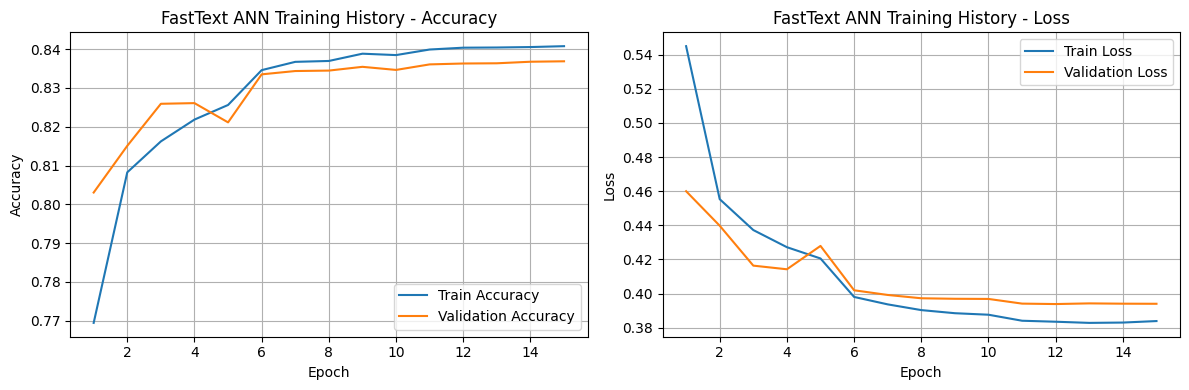

In [27]:
# Latih model ANN
print(f"\nMemulai pelatihan model: FastText-ANN")
start_time_ann = time.time()

history['fasttext_ann'] = model_tf_ann.fit(
    X_train_pad, y_train,
    epochs=EPOCHS_ANN,
    batch_size=BATCH_SIZE_ANN,
    validation_data=(X_val_pad, y_val),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=1e-6)
    ],
    verbose=1 # Tampilkan progress per epoch
)

end_time_ann = time.time()
print(f"Pelatihan FastText-ANN selesai dalam {end_time_ann - start_time_ann:.2f} detik.")

# Plot hasil pelatihan ANN
plot_history(history['fasttext_ann'], "FastText ANN Training History")

### Model 2: Convolutional Neural Network (CNN)

In [28]:
# --- Eksperimen 2: Convolutional Neural Network (CNN) ---
print("\n--- Eksperimen 2: CNN dengan FastText Embeddings ---")

# Parameter CNN
# EMBEDDING_DIM sudah ada
NUM_FILTERS = 256
FILTER_SIZES = [3, 5] # Ukuran kernel konvolusi
DROPOUT_CNN = 0.4
LEARNING_RATE_CNN = 1e-3
EPOCHS_CNN = 35
BATCH_SIZE_CNN = 128

def build_fasttext_cnn(vocab_size, embedding_dim, embedding_matrix, max_len, num_filters, filter_sizes, output_dim, dropout):
    # Input layer
    input_layer = layers.Input(shape=(max_len,), dtype='int32', name='input_sequence')

    # Embedding layer
    embedding_layer = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix] if embedding_matrix is not None else None,
        input_length=max_len,
        trainable=False, # Freeze embeddings
        name='embedding'
    )(input_layer)

    # Dropout setelah embedding (opsional tapi sering digunakan)
    embedded_dropout = layers.Dropout(dropout, name='embedding_dropout')(embedding_layer)

    # Branch konvolusi paralel untuk setiap ukuran filter
    conv_blocks = []
    for filter_size in filter_sizes:
        conv = layers.Conv1D(
            filters=num_filters,
            kernel_size=filter_size,
            padding='valid', # 'valid' berarti tanpa padding di Conv1D
            activation=None, # Aktivasi setelah Batch Norm
            name=f'conv1d_{filter_size}'
        )(embedded_dropout)
        conv = layers.BatchNormalization(name=f'batchnorm_{filter_size}')(conv)
        conv = layers.LeakyReLU(name=f'leakyrelu_{filter_size}')(conv)
        # Global Max Pooling untuk mengambil fitur terpenting dari hasil konvolusi
        conv = layers.GlobalMaxPooling1D(name=f'globalmaxpool_{filter_size}')(conv)
        conv_blocks.append(conv)

    # Concatenate hasil dari semua branch konvolusi
    concatenated = layers.Concatenate(axis=-1, name='concatenate')(conv_blocks)

    # Dropout sebelum fully connected layer
    concat_dropout = layers.Dropout(dropout, name='concat_dropout')(concatenated)

    # Output Layer
    activation_func = 'softmax' if output_dim > 2 else ('sigmoid' if output_dim == 2 else 'linear')
    if output_dim == 2: activation_func = 'sigmoid' # Koreksi untuk biner
    if output_dim == 1 and NUM_CLASSES == 2: activation_func = 'sigmoid' # Jika biner 0/1

    final_units = NUM_CLASSES if NUM_CLASSES > 2 else (1 if NUM_CLASSES==2 else NUM_CLASSES)

    output_layer = layers.Dense(final_units, activation=activation_func, name='output')(concat_dropout)

    # Buat model
    model = keras.Model(inputs=input_layer, outputs=output_layer, name="FastText_CNN")
    return model

# Bangun model CNN
model_tf_cnn = build_fasttext_cnn(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    embedding_matrix=embedding_matrix,
    max_len=MAX_LEN,
    num_filters=NUM_FILTERS,
    filter_sizes=FILTER_SIZES,
    output_dim=NUM_CLASSES,
    dropout=DROPOUT_CNN
)

# Compile model CNN
optimizer_cnn_tf = keras.optimizers.Adam(learning_rate=LEARNING_RATE_CNN)

model_tf_cnn.compile(
    optimizer=optimizer_cnn_tf,
    loss=loss_function, # Gunakan loss function yang sama dengan ANN
    metrics=['accuracy']
)

model_tf_cnn.summary() # Tampilkan arsitektur model


--- Eksperimen 2: CNN dengan FastText Embeddings ---
Model: "FastText_CNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_sequence (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 128, 300)     6000000     ['input_sequence[0][0]']         
                                                                                                  
 embedding_dropout (Dropout)    (None, 128, 300)     0           ['embedding[0][0]']              
                                                                                                  
 conv1d_3 (Conv1D)              (None, 126, 256)     230656      ['embedding_dropout[0][0]']      
                                 


Memulai pelatihan model: FastText-CNN
Epoch 1/35
480/480 [==============================] - 22s 44ms/step - loss: 0.9554 - accuracy: 0.7349 - val_loss: 0.5707 - val_accuracy: 0.7448 - lr: 0.0010
Epoch 2/35
480/480 [==============================] - 21s 43ms/step - loss: 0.4836 - accuracy: 0.8080 - val_loss: 0.4244 - val_accuracy: 0.8264 - lr: 0.0010
Epoch 3/35
480/480 [==============================] - 21s 43ms/step - loss: 0.4486 - accuracy: 0.8210 - val_loss: 0.3974 - val_accuracy: 0.8417 - lr: 0.0010
Epoch 4/35
480/480 [==============================] - 21s 43ms/step - loss: 0.4258 - accuracy: 0.8301 - val_loss: 0.3887 - val_accuracy: 0.8483 - lr: 0.0010
Epoch 5/35
480/480 [==============================] - 21s 43ms/step - loss: 0.4129 - accuracy: 0.8358 - val_loss: 0.3782 - val_accuracy: 0.8514 - lr: 0.0010
Epoch 6/35
480/480 [==============================] - 21s 44ms/step - loss: 0.4021 - accuracy: 0.8403 - val_loss: 0.3768 - val_accuracy: 0.8528 - lr: 0.0010
Epoch 7/35
480/480 

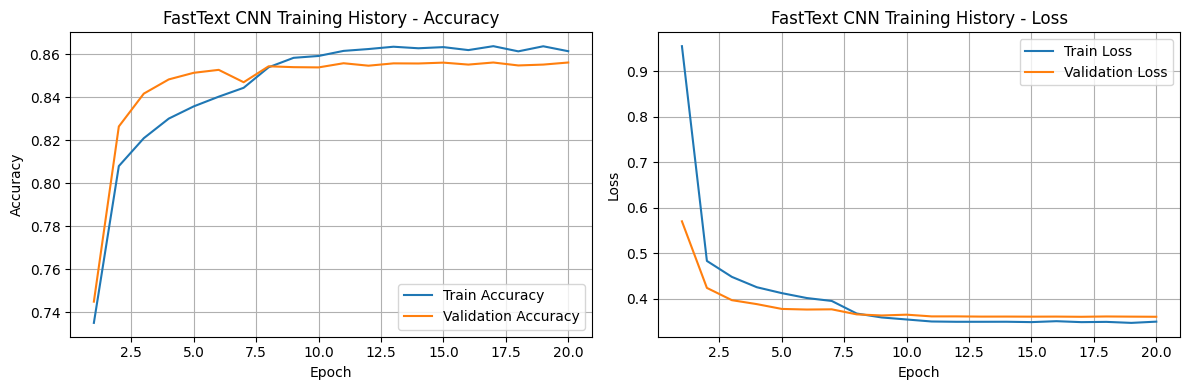

In [29]:
# Latih model CNN
print(f"\nMemulai pelatihan model: FastText-CNN")
start_time_cnn = time.time()

history['fasttext_cnn'] = model_tf_cnn.fit(
    X_train_pad, y_train,
    epochs=EPOCHS_CNN,
    batch_size=BATCH_SIZE_CNN,
    validation_data=(X_val_pad, y_val),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=1e-6)
    ],
    verbose=1
)

end_time_cnn = time.time()
print(f"Pelatihan FastText-CNN selesai dalam {end_time_cnn - start_time_cnn:.2f} detik.")

# Plot hasil pelatihan CNN
plot_history(history['fasttext_cnn'], "FastText CNN Training History")

### Model 3: Random Forest (RF)

In [30]:
# --- Eksperimen 3: Random Forest (RF) ---
print("\n--- Eksperimen 3: Random Forest (RF) ---")
model_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,   
    min_samples_split=5, 
    min_samples_leaf=2,   
    random_state=42,
    n_jobs=-1             
)

print("Melatih Random Forest...")
start_time_rf = time.time()
model_rf.fit(X_train_tfidf, y_train)
end_time_rf = time.time()
print(f"Pelatihan RF selesai. Waktu: {end_time_rf - start_time_rf:.2f} detik.")

# Evaluasi cepat di data latih & validasi (untuk perbandingan kasar)
acc_train_rf = model_rf.score(X_train_tfidf, y_train)
acc_val_rf = model_rf.score(X_val_tfidf, y_val)
print(f"Akurasi RF - Train: {acc_train_rf:.4f}, Validation: {acc_val_rf:.4f}")
history['rf'] = {'model': model_rf, 'train_accuracy': acc_train_rf, 'val_accuracy': acc_val_rf}


--- Eksperimen 3: Random Forest (RF) ---
Melatih Random Forest...
Pelatihan RF selesai. Waktu: 17.11 detik.
Akurasi RF - Train: 0.9048, Validation: 0.8309


### Model 4: XGBoost

In [31]:
# --- Eksperimen 4: XGBoost ---
print("\n--- Eksperimen 4: XGBoost ---")

# Parameter XGBoost
params = {
    'objective': 'multi:softmax',
    'num_class': NUM_CLASSES,
    'max_depth': 7,
    'eta': 0.1,  # learning rate
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',
    'eval_metric': 'mlogloss',
    'random_state': 42
}

print("Melatih XGBoost...")
start_time_xgb = time.time()

# Konversi data ke format DMatrix XGBoost
dtrain = xgb.DMatrix(X_train_tfidf, label=y_train)
dval = xgb.DMatrix(X_val_tfidf, label=y_val)

# Train dengan early stopping
model_xgb = xgb.train(
    params,
    dtrain,
    num_boost_round=300,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    early_stopping_rounds=20,
    verbose_eval=False  # Set True untuk lihat progres per iterasi
)

end_time_xgb = time.time()
print(f"Pelatihan XGBoost selesai. Waktu: {end_time_xgb - start_time_xgb:.2f} detik.")

# Evaluasi cepat
preds_train = model_xgb.predict(dtrain)
preds_val = model_xgb.predict(dval)
acc_train_xgb = (preds_train == y_train).mean()
acc_val_xgb = (preds_val == y_val).mean()
print(f"Akurasi XGBoost - Train: {acc_train_xgb:.4f}, Validation: {acc_val_xgb:.4f}")
history['xgb'] = {'model': model_xgb, 'train_accuracy': acc_train_xgb, 'val_accuracy': acc_val_xgb}


--- Eksperimen 4: XGBoost ---
Melatih XGBoost...
Pelatihan XGBoost selesai. Waktu: 49.17 detik.
Akurasi XGBoost - Train: 0.8776, Validation: 0.8386


### Model 5: LightGBM

In [32]:
# --- Eksperimen 5: LightGBM ---
print("\n--- Eksperimen 5: LightGBM ---")
model_lgbm = lgbm.LGBMClassifier(
    objective='multiclass',
    num_class=NUM_CLASSES,
    n_estimators=300,
    learning_rate=0.1,
    num_leaves=32,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)

print("Melatih LightGBM...")
start_time_lgbm = time.time()
# Gunakan data validasi untuk early stopping
eval_set_lgbm = [(X_val_tfidf, y_val)]

model_lgbm.fit(X_train_tfidf, y_train,
               eval_set=eval_set_lgbm,
               eval_metric='multi_logloss',
               # Callback untuk early stopping dalam API scikit-learn
               callbacks=[lgbm.early_stopping(stopping_rounds=20, verbose=False)]
              )
end_time_lgbm = time.time()
print(f"Pelatihan LightGBM selesai. Waktu: {end_time_lgbm - start_time_lgbm:.2f} detik.")

# Evaluasi cepat
acc_train_lgbm = model_lgbm.score(X_train_tfidf, y_train)
acc_val_lgbm = model_lgbm.score(X_val_tfidf, y_val)
print(f"Akurasi LightGBM - Train: {acc_train_lgbm:.4f}, Validation: {acc_val_lgbm:.4f}")
history['lgbm'] = {'model': model_lgbm, 'train_accuracy': acc_train_lgbm, 'val_accuracy': acc_val_lgbm}


--- Eksperimen 5: LightGBM ---
Melatih LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 84737
[LightGBM] [Info] Number of data points in the train set: 61339, number of used features: 563
[LightGBM] [Info] Start training from score -1.136457
[LightGBM] [Info] Start training from score -1.088604
[LightGBM] [Info] Start training from score -1.071893
Pelatihan LightGBM selesai. Waktu: 10.61 detik.
Akurasi LightGBM - Train: 0.8827, Validation: 0.8466


## Fase 7: Evaluasi & Pemilihan Model Terbaik

In [33]:
print("\nTahap 8: Evaluasi & Pemilihan Model Terbaik")

results = {}
best_model_name = None
best_test_accuracy = 0.0
best_val_accuracy = 0.0 # Gunakan akurasi validasi sebagai kriteria utama


Tahap 8: Evaluasi & Pemilihan Model Terbaik


### ANN

In [34]:
# --- Evaluasi ANN  ---
# Gunakan key yang benar saat menyimpan history dari .fit()
if 'fasttext_ann' in history and model_tf_ann is not None:
    print("\nMengevaluasi ANN ...")
    # Dapatkan prediksi probabilitas dari model
    y_pred_proba_ann = model_tf_ann.predict(X_test_pad)
    # Konversi probabilitas ke kelas prediksi (indeks kelas dengan probabilitas tertinggi)
    y_pred_ann = np.argmax(y_pred_proba_ann, axis=1)

    # Hitung akurasi test
    acc_test_ann = accuracy_score(y_test, y_pred_ann)

    # Tentukan kunci metrik yang benar
    keras_val_acc_key = 'val_accuracy' if 'val_accuracy' in history['fasttext_ann'].history else ('val_acc' if 'val_acc' in history['fasttext_ann'].history else None)
    if keras_val_acc_key:
        val_acc_ann = max(history['fasttext_ann'].history[keras_val_acc_key])
    else:
        print(f"Warning: Metric validasi ('val_accuracy' atau 'val_acc') tidak ditemukan di history ANN. Setting val_acc ke 0.")
        val_acc_ann = 0.0
    
    # Ambil akurasi training terbaik dari history Keras
    keras_train_acc_key = 'accuracy' if 'accuracy' in history['fasttext_ann'].history else ('acc' if 'acc' in history['fasttext_ann'].history else None)
    if keras_train_acc_key:
        train_acc_ann = max(history['fasttext_ann'].history[keras_train_acc_key])
    else:
        print(f"Warning: Metric training ('accuracy' atau 'acc') tidak ditemukan di history ANN. Setting train_acc ke 0.")
        train_acc_ann = 0.0
    
    results['ANN'] = {'train_acc': train_acc_ann, 'val_acc': val_acc_ann, 'test_acc': acc_test_ann}
    print(f"\\nANN :")
    print(f"  Train Acc (Best): {train_acc_ann:.4f}, Val Acc (Best): {val_acc_ann:.4f}, Test Acc: {acc_test_ann:.4f}")
    print("  Classification Report (Test Set):")
    print(classification_report(y_test, y_pred_ann, target_names=label_encoder.classes_, zero_division=0))
    
    # --- Logika pemilihan model terbaik (tetap sama) ---
    if val_acc_ann > best_val_accuracy and acc_test_ann >= 0.85: # Memenuhi syarat minimal test acc
       if acc_test_ann >= 0.92 and train_acc_ann >= 0.92: # Memenuhi syarat ideal
            best_val_accuracy = val_acc_ann
            best_test_accuracy = acc_test_ann
            best_model_name = 'ANN' # Ganti nama
            print(f"*** ANN menjadi kandidat terbaik (Ideal) ***")
       elif best_model_name is None or not (results.get(best_model_name, {}).get('test_acc', 0) >= 0.92 and results.get(best_model_name, {}).get('train_acc', 0) >= 0.92):
           # Hanya update jika belum ada model sama sekali, ATAU
           # jika model terbaik saat ini BUKAN model ideal
           best_val_accuracy = val_acc_ann
           best_test_accuracy = acc_test_ann
           best_model_name = 'ANN' # Ganti nama
           print(f"*** ANN menjadi kandidat terbaik (Memenuhi Min >85%) ***")

else:
    print("\nANN  tidak dievaluasi (tidak ditemukan di history atau model=None).")


Mengevaluasi ANN ...
274/274 [==============================] - 1s 4ms/step
\nANN :
  Train Acc (Best): 0.8408, Val Acc (Best): 0.8369, Test Acc: 0.8415
  Classification Report (Test Set):
              precision    recall  f1-score   support

    negative       0.81      0.82      0.82      2813
     neutral       0.79      0.76      0.78      2950
    positive       0.92      0.94      0.93      3000

    accuracy                           0.84      8763
   macro avg       0.84      0.84      0.84      8763
weighted avg       0.84      0.84      0.84      8763



### CNN

In [35]:
# --- Evaluasi CNN ---
# Gunakan key yang benar saat menyimpan history dari .fit()
if 'fasttext_cnn' in history and model_tf_cnn is not None:
    print("\nMengevaluasi CNN ...")
    # Dapatkan prediksi probabilitas
    y_pred_proba_cnn = model_tf_cnn.predict(X_test_pad)
    # Konversi ke kelas prediksi
    y_pred_cnn = np.argmax(y_pred_proba_cnn, axis=1)

    # Hitung akurasi test
    acc_test_cnn = accuracy_score(y_test, y_pred_cnn)

        # Ambil akurasi validasi terbaik dari history Keras
    keras_val_acc_key_cnn = 'val_accuracy' if 'val_accuracy' in history['fasttext_cnn'].history else ('val_acc' if 'val_acc' in history['fasttext_cnn'].history else None)
    if keras_val_acc_key_cnn:
        val_acc_cnn = max(history['fasttext_cnn'].history[keras_val_acc_key_cnn])
    else:
        print(f"Warning: Metric validasi ('val_accuracy' atau 'val_acc') tidak ditemukan di history CNN. Setting val_acc ke 0.")
        val_acc_cnn = 0.0
    
    # Ambil akurasi training terbaik dari history Keras
    keras_train_acc_key_cnn = 'accuracy' if 'accuracy' in history['fasttext_cnn'].history else ('acc' if 'acc' in history['fasttext_cnn'].history else None)
    if keras_train_acc_key_cnn:
        train_acc_cnn = max(history['fasttext_cnn'].history[keras_train_acc_key_cnn])
    else:
        print(f"Warning: Metric training ('accuracy' atau 'acc') tidak ditemukan di history CNN. Setting train_acc ke 0.")
        train_acc_cnn = 0.0
    
    results['CNN'] = {'train_acc': train_acc_cnn, 'val_acc': val_acc_cnn, 'test_acc': acc_test_cnn}
    print(f"\\nCNN :")
    print(f"  Train Acc (Best): {train_acc_cnn:.4f}, Val Acc (Best): {val_acc_cnn:.4f}, Test Acc: {acc_test_cnn:.4f}")
    print("  Classification Report (Test Set):")
    print(classification_report(y_test, y_pred_cnn, target_names=label_encoder.classes_, zero_division=0))
    
    # --- Logika pemilihan model terbaik (tetap sama) ---
    if val_acc_cnn > best_val_accuracy and acc_test_cnn >= 0.85:
       if acc_test_cnn >= 0.92 and train_acc_cnn >= 0.92:
            best_val_accuracy = val_acc_cnn
            best_test_accuracy = acc_test_cnn
            best_model_name = 'CNN' # Ganti nama
            print(f"*** CNN menjadi kandidat terbaik (Ideal) ***")
       elif best_model_name is None or not (results.get(best_model_name, {}).get('test_acc', 0) >= 0.92 and results.get(best_model_name, {}).get('train_acc', 0) >= 0.92):
           best_val_accuracy = val_acc_cnn
           best_test_accuracy = acc_test_cnn
           best_model_name = 'CNN' # Ganti nama
           print(f"*** CNN menjadi kandidat terbaik (Memenuhi Min >85%) ***")

else:
    print("\nCNN  tidak dievaluasi (tidak ditemukan di history atau model=None).")


Mengevaluasi CNN ...
274/274 [==============================] - 2s 5ms/step
\nCNN :
  Train Acc (Best): 0.8638, Val Acc (Best): 0.8562, Test Acc: 0.8636
  Classification Report (Test Set):
              precision    recall  f1-score   support

    negative       0.89      0.79      0.84      2813
     neutral       0.78      0.86      0.81      2950
    positive       0.93      0.94      0.94      3000

    accuracy                           0.86      8763
   macro avg       0.87      0.86      0.86      8763
weighted avg       0.87      0.86      0.86      8763

*** CNN menjadi kandidat terbaik (Memenuhi Min >85%) ***


### Random Forest

In [36]:
# --- Evaluasi Random Forest ---
if 'rf' in history:
    model_rf = history['rf']['model']
    y_pred_rf = model_rf.predict(X_test_tfidf)
    acc_test_rf = accuracy_score(y_test, y_pred_rf)
    val_acc_rf = history['rf']['val_accuracy']
    train_acc_rf = history['rf']['train_accuracy']
    results['RF'] = {'train_acc': train_acc_rf, 'val_acc': val_acc_rf, 'test_acc': acc_test_rf}
    print(f"\nRandom Forest:")
    print(f"  Train Acc: {train_acc_rf:.4f}, Val Acc: {val_acc_rf:.4f}, Test Acc: {acc_test_rf:.4f}")
    print("  Classification Report (Test Set):")
    print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))
    if val_acc_rf > best_val_accuracy and acc_test_rf >= 0.85:
       if acc_test_rf >= 0.92 and train_acc_rf >= 0.92:
            best_val_accuracy = val_acc_rf
            best_test_accuracy = acc_test_rf
            best_model_name = 'RF'
       elif best_model_name is None or (results[best_model_name]['test_acc'] < 0.92 or results[best_model_name]['train_acc'] < 0.92):
           best_val_accuracy = val_acc_rf
           best_test_accuracy = acc_test_rf
           best_model_name = 'RF'


Random Forest:
  Train Acc: 0.9048, Val Acc: 0.8309, Test Acc: 0.8349
  Classification Report (Test Set):
              precision    recall  f1-score   support

    negative       0.81      0.83      0.82      2813
     neutral       0.79      0.76      0.77      2950
    positive       0.90      0.92      0.91      3000

    accuracy                           0.83      8763
   macro avg       0.83      0.83      0.83      8763
weighted avg       0.83      0.83      0.83      8763



### XGBoost

In [37]:
# --- Evaluasi XGBoost ---
if 'xgb' in history:
    # Pastikan model_xgb adalah objek Booster dari xgb.train
    model_xgb = history['xgb']['model']
    if isinstance(model_xgb, xgb.Booster): # Tambahkan pengecekan tipe untuk keamanan
        print("\nModel XGBoost adalah Native Booster. Mengonversi data test ke DMatrix...")
        # Konversi data test TF-IDF ke DMatrix
        dtest_xgb = xgb.DMatrix(X_test_tfidf) # Tidak perlu label untuk prediksi

        print("Melakukan prediksi XGBoost...")
        y_pred_xgb = model_xgb.predict(dtest_xgb) # Gunakan DMatrix untuk prediksi
        # Hasil predict dari multi:softmax biasanya float, perlu dibulatkan/di-cast jika perlu
        # Namun, accuracy_score biasanya bisa menangani ini. Jika ada error, cast ke int:
        # y_pred_xgb = y_pred_xgb.astype(int)

        acc_test_xgb = accuracy_score(y_test, y_pred_xgb)
        val_acc_xgb = history['xgb']['val_accuracy'] # Akurasi validasi saat early stopping
        train_acc_xgb = history['xgb']['train_accuracy']
        results['XGBoost'] = {'train_acc': train_acc_xgb, 'val_acc': val_acc_xgb, 'test_acc': acc_test_xgb}

        print(f"\nXGBoost:")
        print(f"  Train Acc: {train_acc_xgb:.4f}, Val Acc: {val_acc_xgb:.4f}, Test Acc: {acc_test_xgb:.4f}")
        print("  Classification Report (Test Set):")
        # Pastikan y_pred_xgb dan y_test memiliki tipe yang bisa dibandingkan (biasanya int)
        print(classification_report(y_test, y_pred_xgb.astype(int), target_names=label_encoder.classes_, zero_division=0)) # Tambahkan zero_division

        # Logika pemilihan model terbaik (tetap sama, tambahkan print untuk kejelasan)
        if val_acc_xgb > best_val_accuracy and acc_test_xgb >= 0.85:
           if acc_test_xgb >= 0.92 and train_acc_xgb >= 0.92:
                best_val_accuracy = val_acc_xgb
                best_test_accuracy = acc_test_xgb
                best_model_name = 'XGBoost'
                print(f"*** XGBoost menjadi kandidat terbaik (Ideal) ***")
           elif best_model_name is None or not (results.get(best_model_name, {}).get('test_acc', 0) >= 0.92 and results.get(best_model_name, {}).get('train_acc', 0) >= 0.92):
               best_val_accuracy = val_acc_xgb
               best_test_accuracy = acc_test_xgb
               best_model_name = 'XGBoost'
               print(f"*** XGBoost menjadi kandidat terbaik (Memenuhi Min >85%) ***")

else:
     print("\nXGBoost tidak dievaluasi (tidak ditemukan di history).")


Model XGBoost adalah Native Booster. Mengonversi data test ke DMatrix...
Melakukan prediksi XGBoost...

XGBoost:
  Train Acc: 0.8776, Val Acc: 0.8386, Test Acc: 0.8417
  Classification Report (Test Set):
              precision    recall  f1-score   support

    negative       0.85      0.79      0.82      2813
     neutral       0.76      0.82      0.79      2950
    positive       0.93      0.91      0.92      3000

    accuracy                           0.84      8763
   macro avg       0.84      0.84      0.84      8763
weighted avg       0.85      0.84      0.84      8763



### LightGBM

In [38]:
# --- Evaluasi LightGBM ---
if 'lgbm' in history:
    model_lgbm = history['lgbm']['model']
    y_pred_lgbm = model_lgbm.predict(X_test_tfidf)
    acc_test_lgbm = accuracy_score(y_test, y_pred_lgbm)
    val_acc_lgbm = history['lgbm']['val_accuracy'] # Akurasi validasi saat early stopping
    train_acc_lgbm = history['lgbm']['train_accuracy']
    results['LightGBM'] = {'train_acc': train_acc_lgbm, 'val_acc': val_acc_lgbm, 'test_acc': acc_test_lgbm}
    print(f"\nLightGBM:")
    print(f"  Train Acc: {train_acc_lgbm:.4f}, Val Acc: {val_acc_lgbm:.4f}, Test Acc: {acc_test_lgbm:.4f}")
    print("  Classification Report (Test Set):")
    print(classification_report(y_test, y_pred_lgbm, target_names=label_encoder.classes_))
    if val_acc_lgbm > best_val_accuracy and acc_test_lgbm >= 0.85:
       if acc_test_lgbm >= 0.92 and train_acc_lgbm >= 0.92:
            best_val_accuracy = val_acc_lgbm
            best_test_accuracy = acc_test_lgbm
            best_model_name = 'LightGBM'
       elif best_model_name is None or (results[best_model_name]['test_acc'] < 0.92 or results[best_model_name]['train_acc'] < 0.92):
           best_val_accuracy = val_acc_lgbm
           best_test_accuracy = acc_test_lgbm
           best_model_name = 'LightGBM'


LightGBM:
  Train Acc: 0.8827, Val Acc: 0.8466, Test Acc: 0.8466
  Classification Report (Test Set):
              precision    recall  f1-score   support

    negative       0.85      0.81      0.83      2813
     neutral       0.77      0.81      0.79      2950
    positive       0.93      0.92      0.92      3000

    accuracy                           0.85      8763
   macro avg       0.85      0.85      0.85      8763
weighted avg       0.85      0.85      0.85      8763



### Select Best Model

In [39]:
# --- Pemilihan Model Terbaik ---
print("\n--- Ringkasan Hasil & Pemilihan Model Terbaik ---")
results_df = pd.DataFrame(results).T # Transpose untuk format tabel yang baik
print(results_df.sort_values(by='val_acc', ascending=False))

if best_model_name:
    print(f"\nModel terbaik berdasarkan Akurasi Validasi tertinggi (dan memenuhi syarat akurasi): {best_model_name}")
    print(f"  Akurasi Validasi Terbaik: {best_val_accuracy:.4f}")
    print(f"  Akurasi Test: {best_test_accuracy:.4f}")
    print(f"  Akurasi Train: {results[best_model_name]['train_acc']:.4f}")

    # Cek apakah target akurasi terpenuhi
    if results[best_model_name]['train_acc'] >= 0.92 and results[best_model_name]['test_acc'] >= 0.92:
         print("  Target Akurasi (Train > 92%, Test > 92%) TERPENUHI.")
    elif results[best_model_name]['test_acc'] >= 0.85:
         print("  Target Akurasi (Test > 85%) TERPENUHI.")
    else:
         print("  PERINGATAN: Target Akurasi Minimal (Test > 85%) TIDAK TERPENUHI oleh model terbaik.")

else:
    print("\nTidak ada model yang memenuhi kriteria pemilihan (Val Acc tertinggi & Test Acc >= 85%).")
    # Pilih berdasarkan test accuracy tertinggi saja jika tidak ada yg memenuhi kriteria val acc
    best_model_name_test = results_df[results_df['test_acc'] >= 0.85]['test_acc'].idxmax() if not results_df[results_df['test_acc'] >= 0.85].empty else results_df['test_acc'].idxmax()
    print(f"Model dengan Test Accuracy tertinggi: {best_model_name_test} ({results_df.loc[best_model_name_test, 'test_acc']:.4f})")
    best_model_name = best_model_name_test # Gunakan ini untuk inference


--- Ringkasan Hasil & Pemilihan Model Terbaik ---
          train_acc   val_acc  test_acc
CNN        0.863822  0.856214  0.863631
LightGBM   0.882668  0.846628  0.846628
XGBoost    0.877566  0.838583  0.841721
ANN        0.840770  0.836871  0.841493
RF         0.904775  0.830937  0.834874

Model terbaik berdasarkan Akurasi Validasi tertinggi (dan memenuhi syarat akurasi): CNN
  Akurasi Validasi Terbaik: 0.8562
  Akurasi Test: 0.8636
  Akurasi Train: 0.8638
  Target Akurasi (Test > 85%) TERPENUHI.


## Fase 8: Inference (Pengujian pada Data Baru)

In [40]:
print("\nTahap 9: Inference")

if not best_model_name:
    print("Tidak ada model terbaik yang dipilih, inference tidak dapat dilakukan.")
else:
    print(f"Melakukan inference menggunakan model terbaik: {best_model_name}")

    # --- Map best_model_name to the actual model object ---
    best_model_obj = None
    is_deep_learning_model = False
    is_xgboost_native = False # Flag if the XGBoost model is from xgb.train

    # Ambil model object dari history dictionary atau variabel model langsung
    if best_model_name == 'ANN':
        # Coba ambil dari history dulu
        if 'fasttext_ann' in history and hasattr(history['fasttext_ann'], 'model') and history['fasttext_ann'].model is not None:
            best_model_obj = history['fasttext_ann'].model # Akses atribut .model
            is_deep_learning_model = True
            print("Menggunakan model TensorFlow ANN (dari history).")
        # Fallback ke variabel model jika tidak ada di history
        elif 'model_tf_ann' in locals() and model_tf_ann is not None:
            best_model_obj = model_tf_ann
            is_deep_learning_model = True
            print("Menggunakan model TensorFlow ANN (dari locals).")
        else:
             print(f"ERROR: Model object untuk '{best_model_name}' tidak ditemukan atau None.")
             best_model_name = None

    elif best_model_name == 'CNN':
         # Coba ambil dari history dulu
        if 'fasttext_cnn' in history and hasattr(history['fasttext_cnn'], 'model') and history['fasttext_cnn'].model is not None:
            best_model_obj = history['fasttext_cnn'].model # Akses atribut .model
            is_deep_learning_model = True
            print("Menggunakan model TensorFlow CNN (dari history).")
         # Fallback ke variabel model jika tidak ada di history
        elif 'model_tf_cnn' in locals() and model_tf_cnn is not None:
            best_model_obj = model_tf_cnn
            is_deep_learning_model = True
            print("Menggunakan model TensorFlow CNN (dari locals).")
        else:
             print(f"ERROR: Model object untuk '{best_model_name}' tidak ditemukan atau None.")
             best_model_name = None

    elif best_model_name == 'RF':
        if 'rf' in history and history['rf'].get('model') is not None:
            best_model_obj = history['rf']['model']
            print("Menggunakan model Random Forest (dari history).")
        elif 'model_rf' in locals() and model_rf is not None:
             best_model_obj = model_rf
             print("Menggunakan model Random Forest (dari locals).")
        else:
             print(f"ERROR: Model object untuk '{best_model_name}' tidak ditemukan atau None.")
             best_model_name = None

    elif best_model_name == 'XGBoost': # Sesuaikan dengan key di results
        if 'xgb' in history and history['xgb'].get('model') is not None:
            best_model_obj = history['xgb']['model']
            print("Menggunakan model XGBoost (dari history).")
        elif 'model_xgb' in locals() and model_xgb is not None:
             best_model_obj = model_xgb
             print("Menggunakan model XGBoost (dari locals).")
        else:
             print(f"ERROR: Model object untuk '{best_model_name}' tidak ditemukan atau None.")
             best_model_name = None

        # Cek tipe model XGBoost *setelah* dipastikan tidak None
        if best_model_obj is not None:
             if isinstance(best_model_obj, xgb.Booster):
                 is_xgboost_native = True
                 print("(Model adalah Native API Booster)")
             # else:
             #     print("(Model adalah Scikit-learn API Wrapper)")

    elif best_model_name == 'LightGBM':
        if 'lgbm' in history and history['lgbm'].get('model') is not None:
            best_model_obj = history['lgbm']['model']
            print("Menggunakan model LightGBM (dari history).")
        elif 'model_lgbm' in locals() and model_lgbm is not None:
             best_model_obj = model_lgbm
             print("Menggunakan model LightGBM (dari locals).")
        else:
             print(f"ERROR: Model object untuk '{best_model_name}' tidak ditemukan atau None.")
             best_model_name = None
    else:
        # Kasus jika best_model_name tidak cocok dengan opsi di atas
        print(f"ERROR: Nama model terbaik '{best_model_name}' tidak dikenal atau model tidak ditemukan.")
        best_model_name = None # Reset


Tahap 9: Inference
Melakukan inference menggunakan model terbaik: CNN
Menggunakan model TensorFlow CNN (dari history).


In [41]:
if best_model_name and best_model_obj:
    # Pilih data acak dari Test Set
    try:
        if isinstance(X_test, pd.Series):
            random_idx_loc = random.randint(0, len(X_test) - 1)
            random_idx_orig = X_test.index[random_idx_loc] # Get original index if X_test is Series
            test_sample_text_cleaned = X_test.iloc[random_idx_loc]
            true_label_encoded = y_test[random_idx_loc] # Assuming y_test is aligned by iloc
        else: # Assume X_test and y_test are NumPy arrays
            random_idx_loc = random.randint(0, len(X_test) - 1)
            random_idx_orig = random_idx_loc # Use integer index
            test_sample_text_cleaned = X_test[random_idx_loc]
            true_label_encoded = y_test[random_idx_loc]

        # Cari teks asli dengan penanganan error yang lebih baik
        original_text = "[Teks asli tidak dapat ditemukan]" # Default
        try:
            # Pastikan kolom 'review_text_deep_cleaned' ada di df_final
            if 'review_text_deep_cleaned' in df_final.columns and 'review_text' in df_final.columns:
                original_text_candidates = df_final[df_final['review_text_deep_cleaned'] == test_sample_text_cleaned]
                if not original_text_candidates.empty:
                    # Jika ada duplikat setelah cleaning, ambil yang pertama (mungkin tidak sempurna)
                    original_text = original_text_candidates.iloc[0]['review_text']
                else:
                    original_text = "[Teks asli tidak ditemukan untuk teks cleaned ini]"
                    if isinstance(X_test, pd.Series):
                         random_idx_orig = f"iloc:{random_idx_loc}" # Gunakan iloc jika original index lookup gagal
            else:
                 original_text = "[Kolom teks tidak ditemukan di df_final]"

        except Exception as e:
            print(f"Error saat mencari teks asli: {e}")
            if isinstance(X_test, pd.Series):
                 random_idx_orig = f"iloc:{random_idx_loc}"

        true_label_text = label_encoder.inverse_transform([true_label_encoded])[0]

        print(f"\n--- Contoh Inference ---")
        print(f"Index Sampel: {random_idx_orig} (iloc: {random_idx_loc})")
        print(f"Review Asli: \n{original_text}")
        print(f"\nReview setelah Deep Cleaning: \n{test_sample_text_cleaned}")
        print(f"\nLabel Sebenarnya: {true_label_text} (Encoded: {true_label_encoded})")

        # Preprocessing dan Prediksi sesuai model terbaik
        predicted_label_encoded = -1 # Default

        if is_deep_learning_model:
            # Preprocessing untuk Deep Learning Model 
            test_sample_seq = tokenizer.texts_to_sequences([test_sample_text_cleaned])
            test_sample_pad = pad_sequences(test_sample_seq, maxlen=MAX_LEN, padding='post', truncating='post')

            # Prediksi dengan model Keras
            # Gunakan verbose=0 untuk menekan output progress bar prediksi tunggal
            y_pred_proba = best_model_obj.predict(test_sample_pad, verbose=0)
            predicted_label_encoded = np.argmax(y_pred_proba, axis=1)[0] # Get index of max probability

        else: # Model berbasis TF-IDF (RF, XGB, LGBM)
            test_sample_tfidf = tfidf_vectorizer.transform([test_sample_text_cleaned])

            if is_xgboost_native:
                # XGBoost Native API expects DMatrix
                dtest_sample = xgb.DMatrix(test_sample_tfidf)
                predicted_label_encoded = best_model_obj.predict(dtest_sample)[0]
                predicted_label_encoded = int(predicted_label_encoded) # Output might be float
            else:
                # Scikit-learn compatible models (RF, LGBM, XGB wrapper)
                predicted_label_encoded = best_model_obj.predict(test_sample_tfidf)[0]

        # Konversi hasil prediksi ke label teks
        if predicted_label_encoded != -1:
            predicted_label_text = label_encoder.inverse_transform([predicted_label_encoded])[0]
            print(f"\nPrediksi Model ({best_model_name}): {predicted_label_text} (Encoded: {predicted_label_encoded})")
        else:
            print(f"\nPrediksi Model ({best_model_name}): GAGAL")

        print("-" * 25)

    except IndexError:
         print(f"Error: Gagal mengambil sampel acak dari data test. Pastikan X_test dan y_test tidak kosong dan selaras.")
    except Exception as e:
         print(f"Terjadi error saat melakukan inference pada sampel acak: {e}")


    # --- Fungsi untuk prediksi teks bebas ---
    # Pastikan fungsi deep_clean_text sudah didefinisikan sebelumnya
    def predict_sentiment(text, model_name_func, model_obj_func,
                          tokenizer_dl=None, vectorizer_tfidf=None, label_enc=None,
                          max_len_dl=None, is_dl_func=False, is_xgb_native_func=False):
        if not text or not isinstance(text, str):
             return "Input tidak valid (teks kosong atau bukan string)"

        # 1. Cleaning mendalam
        try:
            # Pastikan deep_clean_text ada
            if 'deep_clean_text' not in globals():
                 return "Error: Fungsi deep_clean_text tidak ditemukan."
            cleaned_text = deep_clean_text(text)
        except Exception as e:
            return f"Error saat cleaning: {e}"

        if not cleaned_text:
            return "Teks menjadi kosong setelah cleaning"

        # 2. Preprocessing & Prediksi
        pred_encoded = -1
        try:
            if is_dl_func: # TensorFlow/Keras Model
                if not tokenizer_dl or not max_len_dl: return "Tokenizer/MaxLen DL tidak disediakan"
                seq = tokenizer_dl.texts_to_sequences([cleaned_text])
                pad = pad_sequences(seq, maxlen=max_len_dl, padding='post', truncating='post')
                # Prediksi Keras dengan verbose=0
                pred_proba = model_obj_func.predict(pad, verbose=0)
                pred_encoded = np.argmax(pred_proba, axis=1)[0]

            else: # Model berbasis TF-IDF
                if not vectorizer_tfidf: return "Vectorizer TF-IDF tidak disediakan"
                tfidf_vec = vectorizer_tfidf.transform([cleaned_text])

                if is_xgb_native_func:
                     # XGBoost Native API expects DMatrix
                     if not isinstance(model_obj_func, xgb.Booster): return "Objek model XGBoost native tidak valid"
                     dtest_vec = xgb.DMatrix(tfidf_vec)
                     pred_encoded = model_obj_func.predict(dtest_vec)[0]
                     pred_encoded = int(pred_encoded) # Convert float to int
                else:
                     # RF, LGBM, XGB Wrapper
                     pred_encoded = model_obj_func.predict(tfidf_vec)[0]

        except AttributeError as ae:
             return f"Error: Attribut tidak ditemukan pada model '{model_name_func}'. Mungkin model tidak dimuat dengan benar? ({ae})"
        except Exception as e:
            return f"Error saat preprocessing/prediksi ({model_name_func}): {e}"

        # 3. Decode label
        if pred_encoded != -1:
            if not label_enc: return "Label Encoder tidak disediakan"
            try:
                 pred_text = label_enc.inverse_transform([pred_encoded])[0]
                 return pred_text
            except Exception as e:
                 return f"Error saat decoding label: {e}"
        else:
            return "Prediksi Gagal (encoded = -1)"

    # Contoh penggunaan fungsi prediksi
    print("\n--- Uji Fungsi Prediksi Teks Bebas ---")
    test_text_1 = "This app is amazing! So easy to use and very helpful features."
    test_text_2 = "Worst app ever. It keeps crashing and losing my data. Stay away!"
    test_text_3 = "It's decent. Does the basic functions but lacks advanced options."
    test_text_4 = "" # Empty text
    test_text_5 = "????? #### !!!! 12345" # Text that might become empty or short after cleaning

    # Panggil fungsi dengan argumen yang benar
    pred1 = predict_sentiment(test_text_1, best_model_name, best_model_obj,
                              tokenizer, tfidf_vectorizer, label_encoder, MAX_LEN,
                              is_deep_learning_model, is_xgboost_native)
    pred2 = predict_sentiment(test_text_2, best_model_name, best_model_obj,
                              tokenizer, tfidf_vectorizer, label_encoder, MAX_LEN,
                              is_deep_learning_model, is_xgboost_native)
    pred3 = predict_sentiment(test_text_3, best_model_name, best_model_obj,
                              tokenizer, tfidf_vectorizer, label_encoder, MAX_LEN,
                              is_deep_learning_model, is_xgboost_native)
    pred4 = predict_sentiment(test_text_4, best_model_name, best_model_obj,
                              tokenizer, tfidf_vectorizer, label_encoder, MAX_LEN,
                              is_deep_learning_model, is_xgboost_native)
    pred5 = predict_sentiment(test_text_5, best_model_name, best_model_obj,
                              tokenizer, tfidf_vectorizer, label_encoder, MAX_LEN,
                              is_deep_learning_model, is_xgboost_native)


    print(f"Teks: '{test_text_1}'\nPrediksi Sentimen ({best_model_name}): {pred1}\n")
    print(f"Teks: '{test_text_2}'\nPrediksi Sentimen ({best_model_name}): {pred2}\n")
    print(f"Teks: '{test_text_3}'\nPrediksi Sentimen ({best_model_name}): {pred3}\n")
    print(f"Teks: '{test_text_4}'\nPrediksi Sentimen ({best_model_name}): {pred4}\n")
    print(f"Teks: '{test_text_5}'\nPrediksi Sentimen ({best_model_name}): {pred5}\n")

else:
     # Kondisi ini sudah ditangani di awal, tapi untuk kelengkapan
     print("Tidak dapat melanjutkan ke pengujian fungsi predict_sentiment karena model terbaik tidak valid.")


--- Contoh Inference ---
Index Sampel: 11201 (iloc: 1679)
Review Asli: 
Nine app

Review setelah Deep Cleaning: 
nine

Label Sebenarnya: neutral (Encoded: 1)

Prediksi Model (CNN): neutral (Encoded: 1)
-------------------------

--- Uji Fungsi Prediksi Teks Bebas ---
Teks: 'This app is amazing! So easy to use and very helpful features.'
Prediksi Sentimen (CNN): positive

Teks: 'Worst app ever. It keeps crashing and losing my data. Stay away!'
Prediksi Sentimen (CNN): negative

Teks: 'It's decent. Does the basic functions but lacks advanced options.'
Prediksi Sentimen (CNN): neutral

Teks: ''
Prediksi Sentimen (CNN): Input tidak valid (teks kosong atau bukan string)

Teks: '????? #### !!!! 12345'
Prediksi Sentimen (CNN): Teks menjadi kosong setelah cleaning

